In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/09/18 16:17:28 WARN Utils: Your hostname, NivethanAsus resolves to a loopback address: 127.0.1.1; using 172.23.147.67 instead (on interface eth0)
23/09/18 16:17:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/18 16:17:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()

+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+--------------------------------+---------------------------+------------------+---------------------------------+--------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|number_of_orders|average_cost_of_order|number_of_postcodes|avg_total_weekly_personal_income|avg_total_weekly_fam_income|    avg_median_age|avg_num_of_consumers_per_postcode|merchant_description|             segment|
+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-

Summary Statistics for average_consumer_fraud_probability:

count    4026.000000
mean        1.023902
std         3.861449
min         0.000000
25%         0.023131
50%         0.054687
75%         0.210249
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



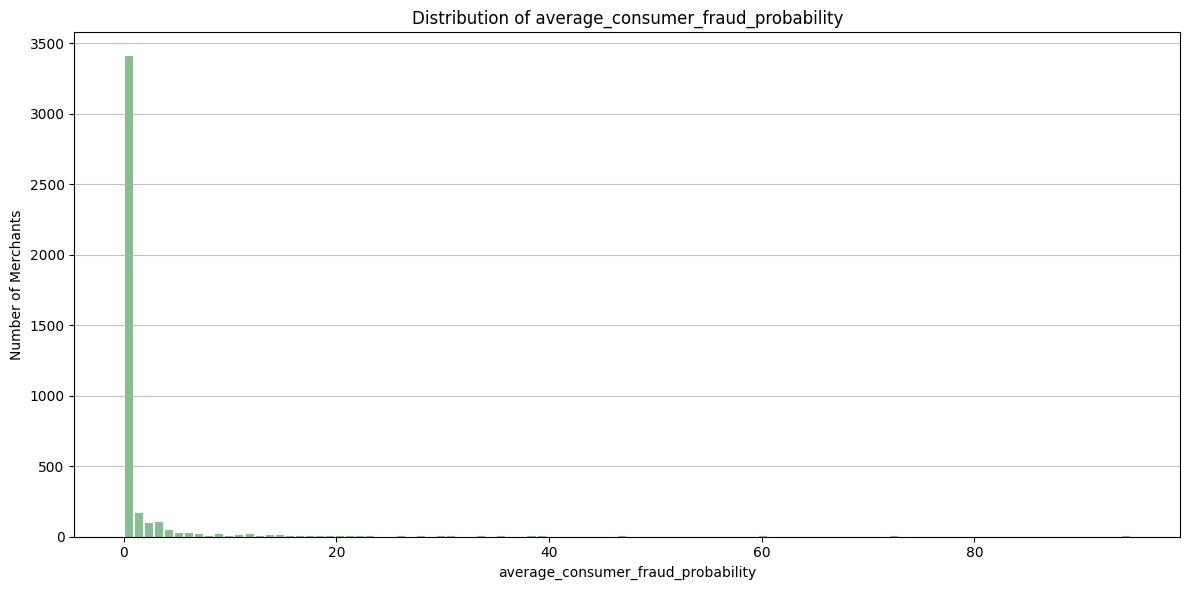

Summary Statistics for avg_median_age:

count    4026.000000
mean       43.112349
std         0.991092
min        26.000000
25%        42.913605
50%        43.107035
75%        43.300379
max        55.000000
Name: avg_median_age, dtype: float64

--------------------------------------------------



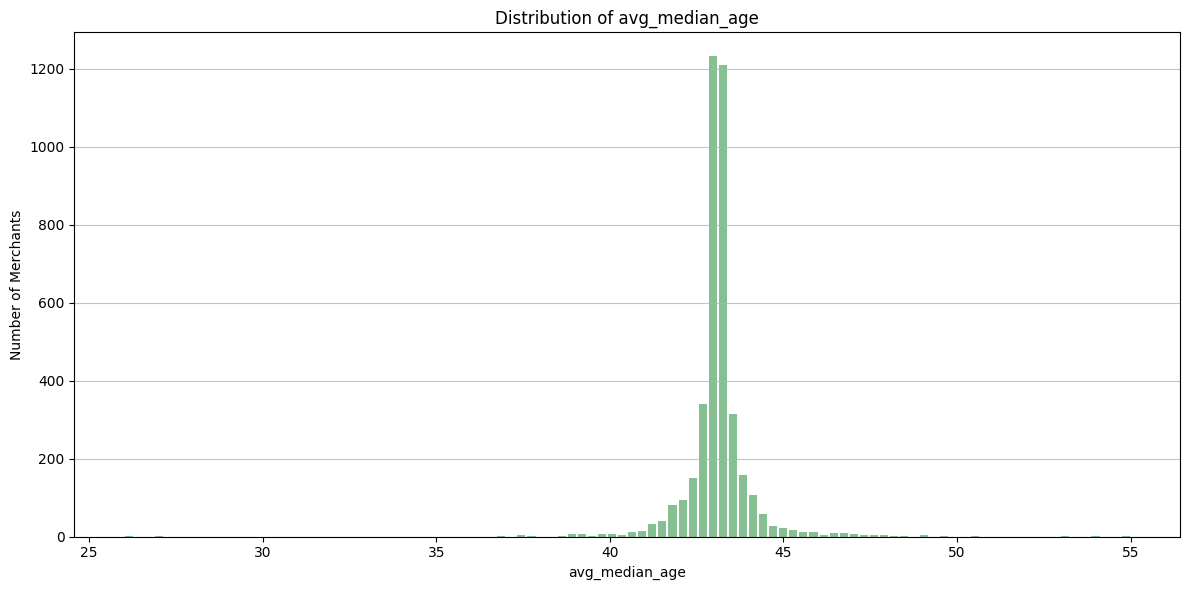

Summary Statistics for avg_total_weekly_personal_income:

count    4026.000000
mean      789.579167
std        30.273343
min       471.000000
25%       782.828468
50%       790.159310
75%       796.630394
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



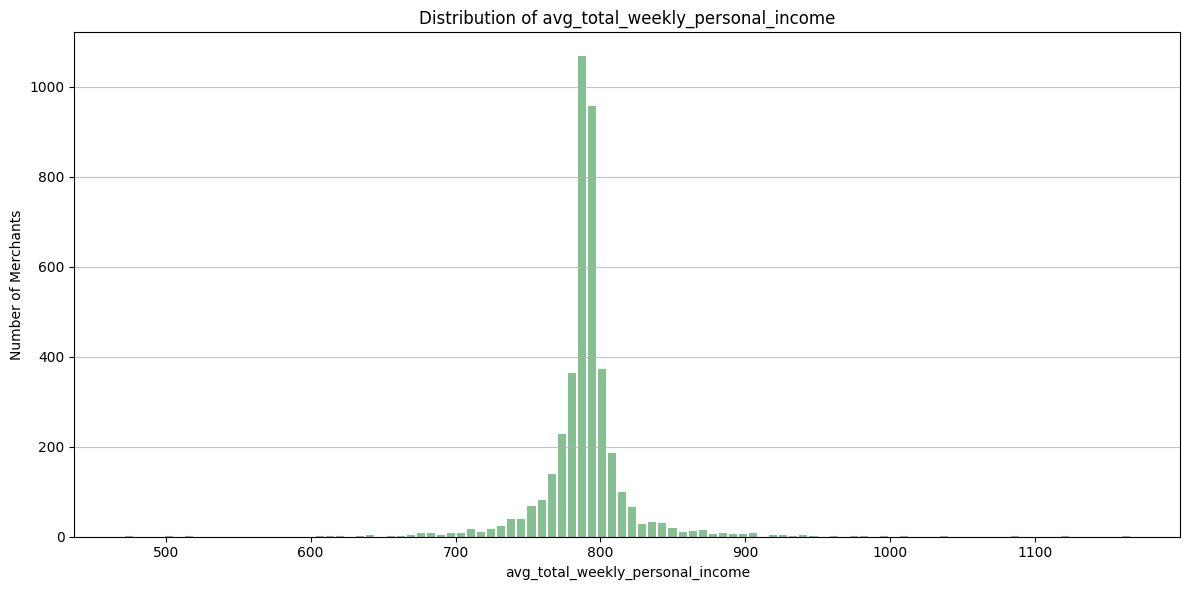

Summary Statistics for take_rate:

count    4026.000000
mean        4.397576
std         1.782595
min         0.100000
25%         2.970000
50%         4.500000
75%         6.030000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



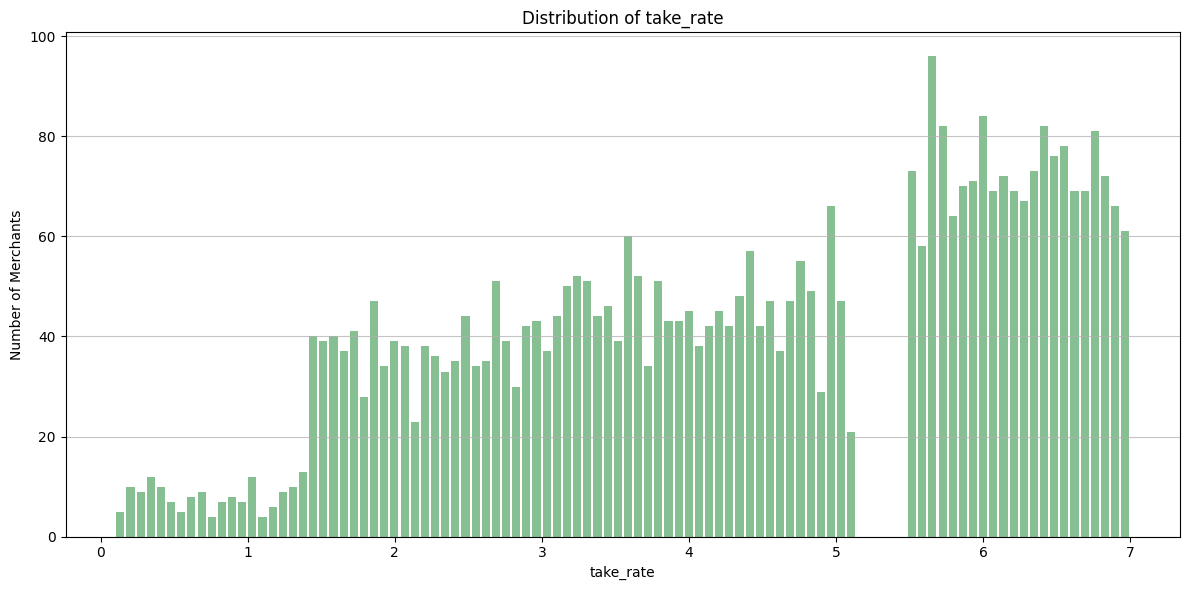

Summary Statistics for average_cost_of_order:

count     4026.000000
mean      1162.394858
std       2972.212606
min          7.579026
25%        118.295487
50%        317.551494
75%        841.489967
max      51876.640000
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



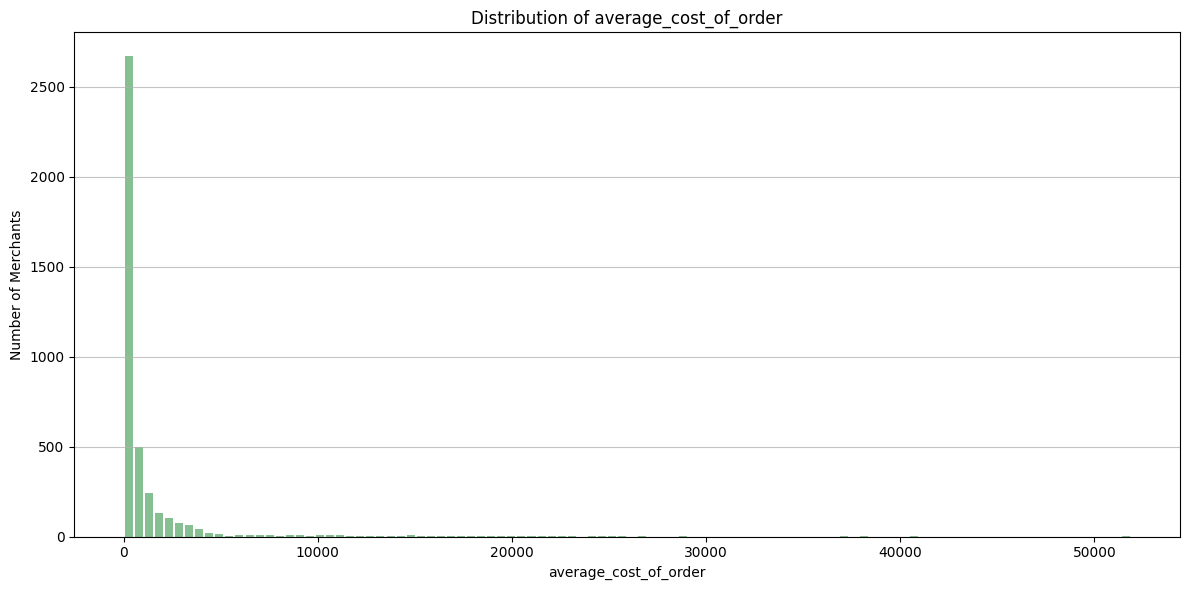

Summary Statistics for number_of_orders:

count      4026.000000
mean       2824.824888
std       11816.655769
min           1.000000
25%          78.250000
50%         352.000000
75%        1718.500000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



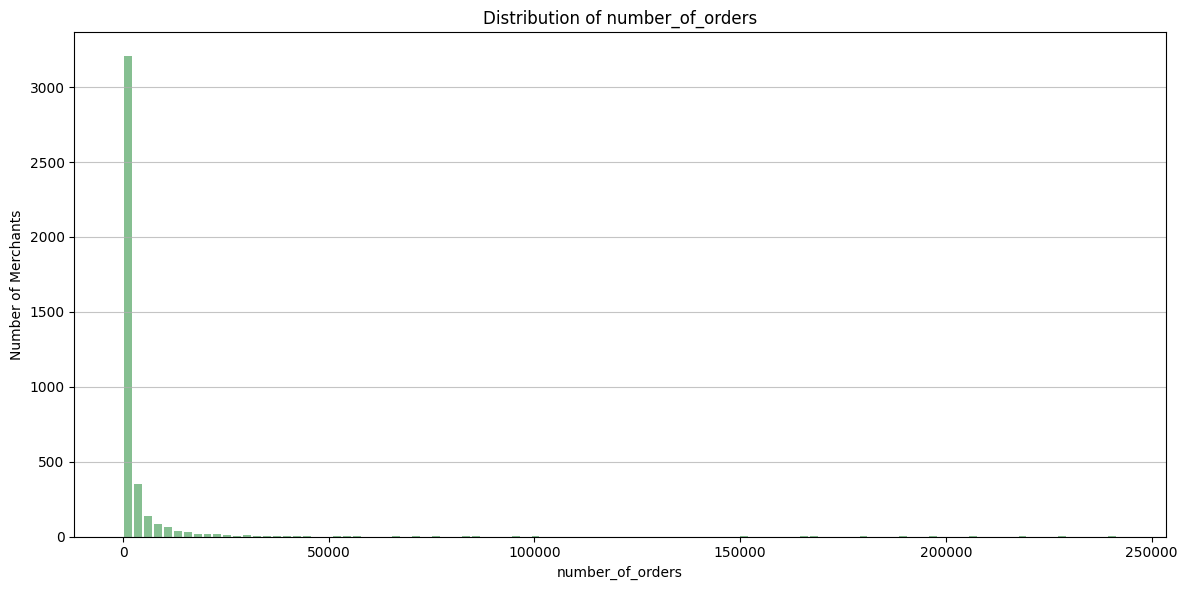

Summary Statistics for number_of_consumers:

count     4026.000000
mean      1691.663189
std       3236.959538
min          1.000000
25%         78.250000
50%        349.000000
75%       1643.500000
max      20115.000000
Name: number_of_consumers, dtype: float64

--------------------------------------------------



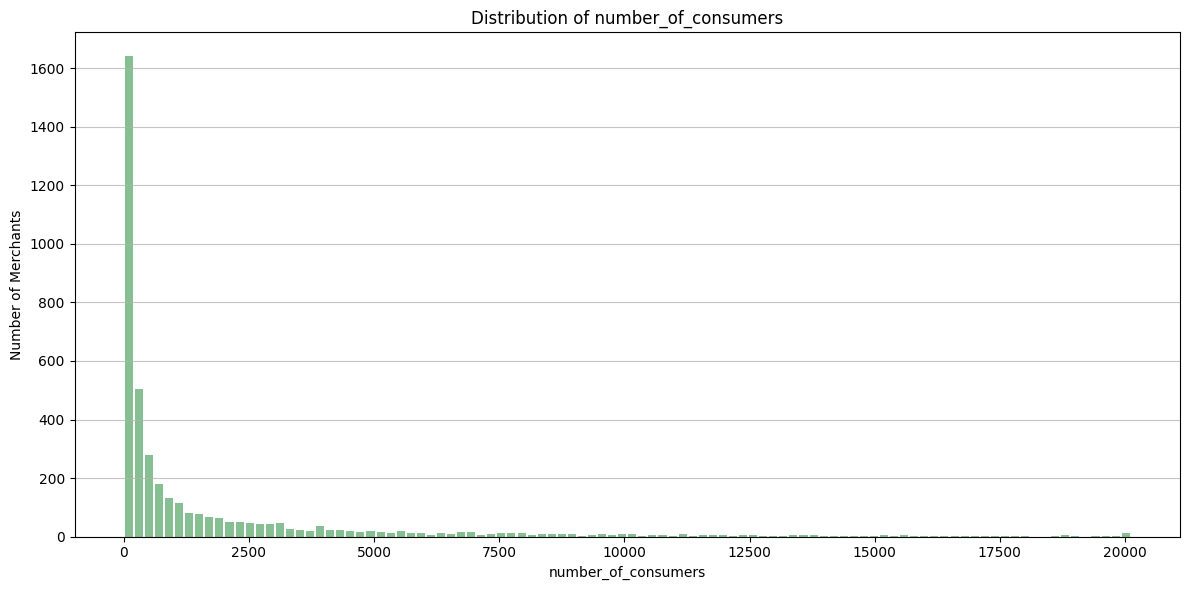

In [4]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_consumers"
]

# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


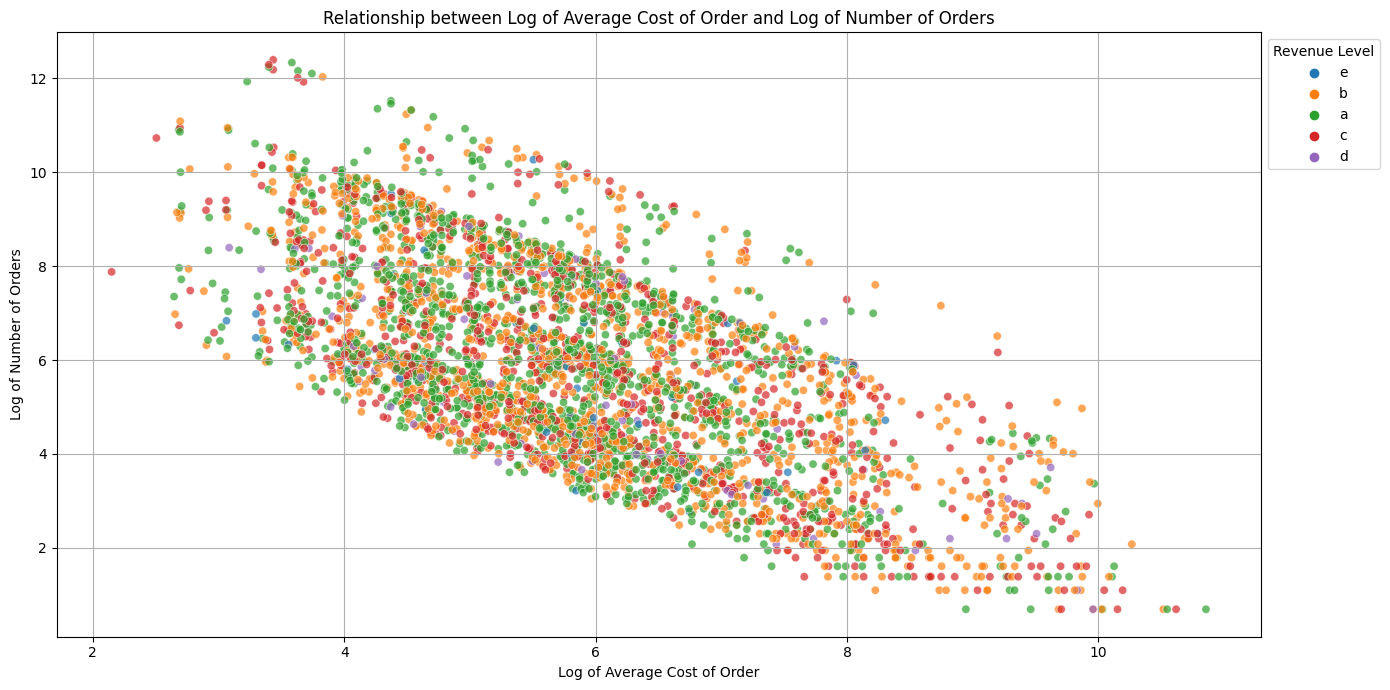

In [5]:
import seaborn as sns
from pyspark.sql.functions import log1p

df = df.withColumn('log_average_cost_of_order', log1p(df['average_cost_of_order']))
df = df.withColumn('log_number_of_orders', log1p(df['number_of_orders']))

# Convert the PySpark dataframe to a pandas dataframe for visualization
df_pandas = df.toPandas()

# Create the scatter plot with revenue_level as hue
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_pandas, x='log_average_cost_of_order', y='log_number_of_orders', hue='revenue_level', palette='tab10', alpha=0.7)
plt.title('Relationship between Log of Average Cost of Order and Log of Number of Orders')
plt.xlabel('Log of Average Cost of Order')
plt.ylabel('Log of Number of Orders')
plt.grid(True)
plt.legend(title='Revenue Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [6]:
from pyspark.sql import functions as F

# Assuming df is your DataFrame
filtered_df = df.filter(
    (F.col("average_merchant_fraud_probability") > 0) 
   # (F.col("average_consumer_fraud_probability") > 0)
)


Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



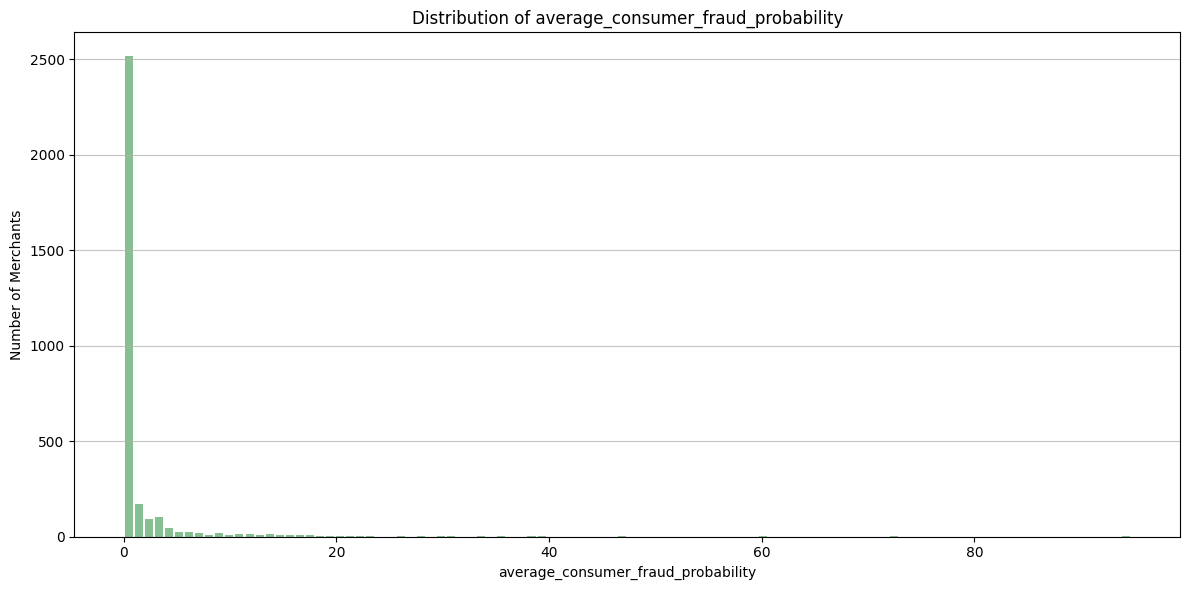

Summary Statistics for average_merchant_fraud_probability:

count    47.000000
mean      1.313311
std       2.898382
min       0.125353
25%       0.259682
50%       0.724312
75%       1.153219
max      18.210900
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



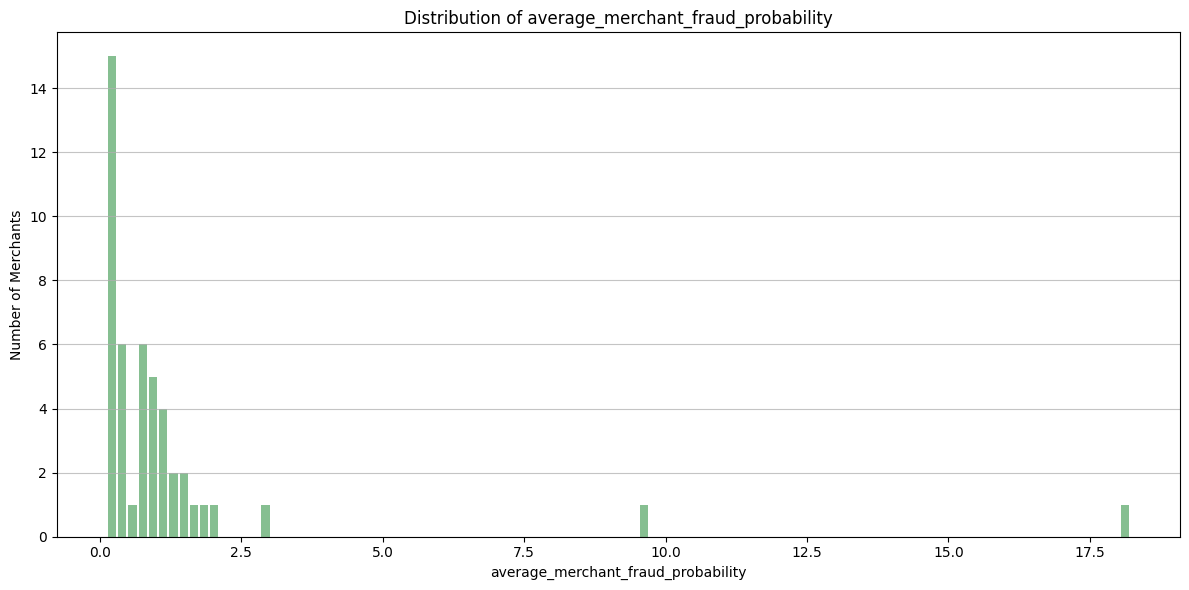

In [7]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "average_merchant_fraud_probability"
]
df_pandas = filtered_df.toPandas()
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    filtered_df = df.filter(
    (F.col(column) > 0) 
)   
    df_pandas = filtered_df.toPandas()
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


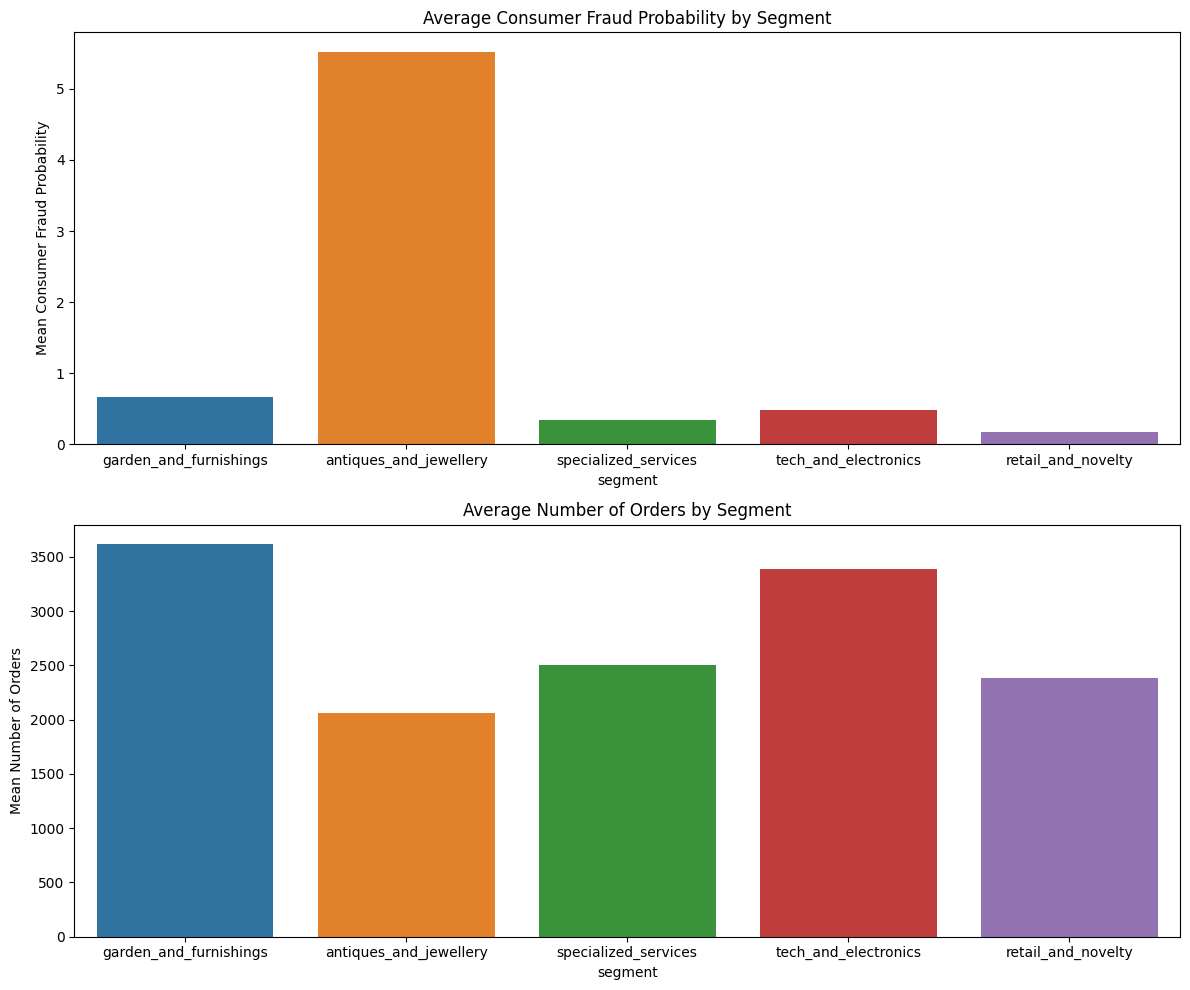

In [8]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Group by segment and aggregate the mean and standard deviation
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()


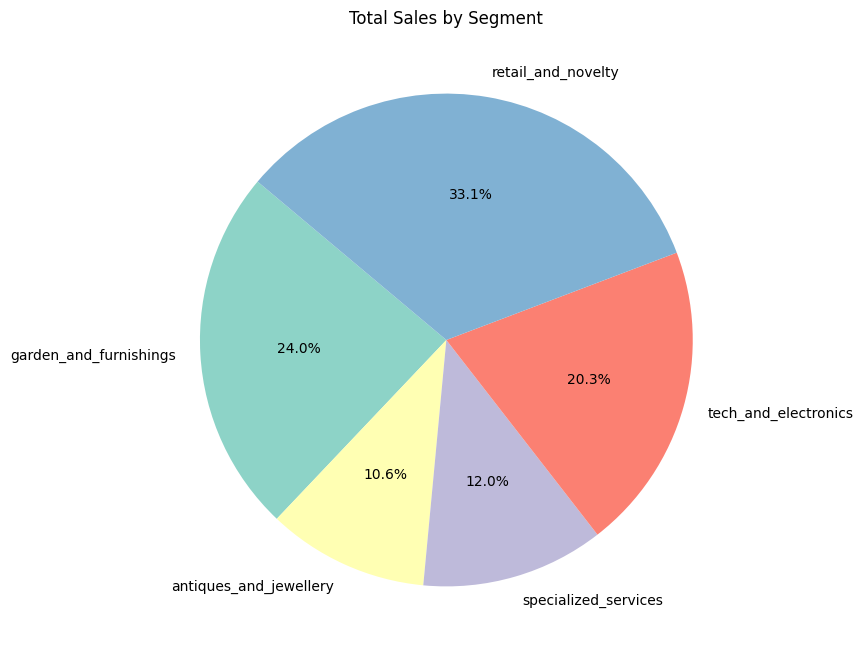

In [9]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()


/tmp/ipykernel_344/3417549059.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


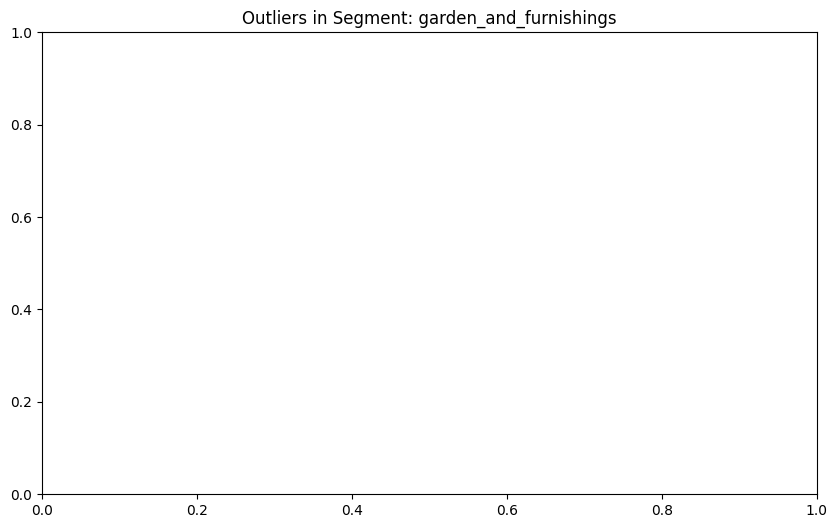

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


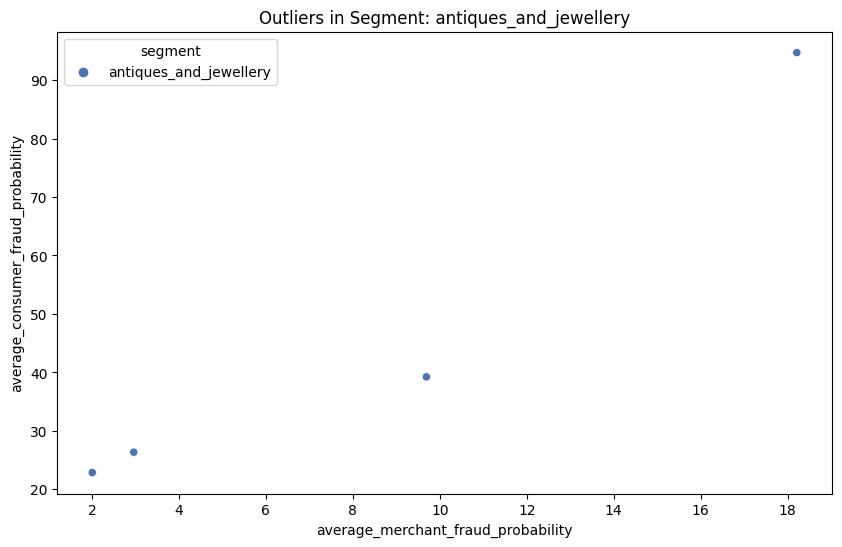

     merchant_abn                               name revenue_level  take_rate  \
11    11149063370                    Et Arcu Limited             b       4.84   
336   67264251405          Elit Dictum Eu Foundation             a       6.40   
414   83199298021     Ligula Elit Pretium Foundation             b       4.82   
445   89109402284  Interdum Feugiat Sed Incorporated             b       3.87   

     average_merchant_fraud_probability  number_of_consumers  \
11                             2.960385                   54   
336                           18.210900                    1   
414                            2.006359                  143   
445                            9.691367                    3   

     average_consumer_fraud_probability  number_of_repeat_consumers  \
11                            26.333317                         NaN   
336                           94.703400                         NaN   
414                           22.849778                     

/tmp/ipykernel_344/3417549059.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


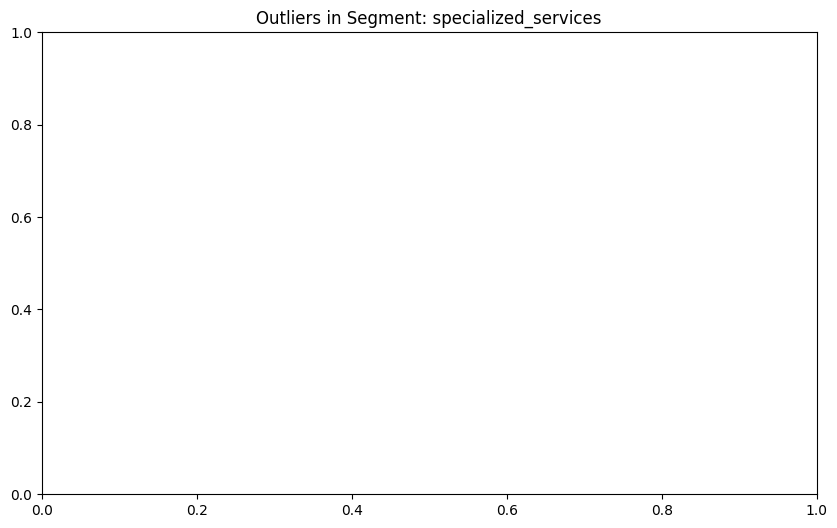

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


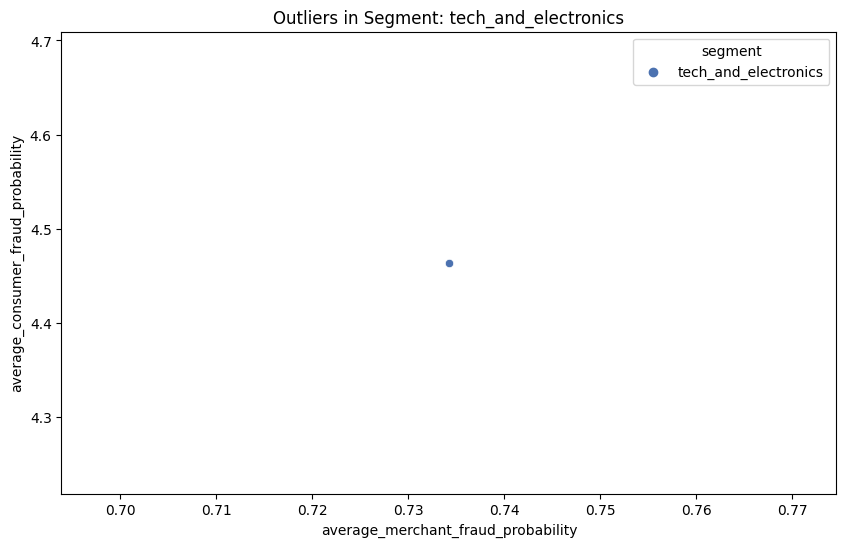

     merchant_abn                     name revenue_level  take_rate  \
803   93260930990  Pede Cras Vulputate Ltd             b       3.15   

     average_merchant_fraud_probability  number_of_consumers  \
803                            0.734226                 1913   

     average_consumer_fraud_probability  number_of_repeat_consumers  \
803                            4.463883                        84.0   

     number_of_orders  average_cost_of_order  number_of_postcodes  \
803              2001            3733.194128                 2001   

     avg_total_weekly_personal_income  avg_total_weekly_fam_income  \
803                        791.914043                  1996.282859   

     avg_median_age  avg_num_of_consumers_per_postcode merchant_description  \
803       43.050475                           1.461651              telecom   

                  segment  log_average_cost_of_order  log_number_of_orders  
803  tech_and_electronics                   8.225287              7.6

/tmp/ipykernel_344/3417549059.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


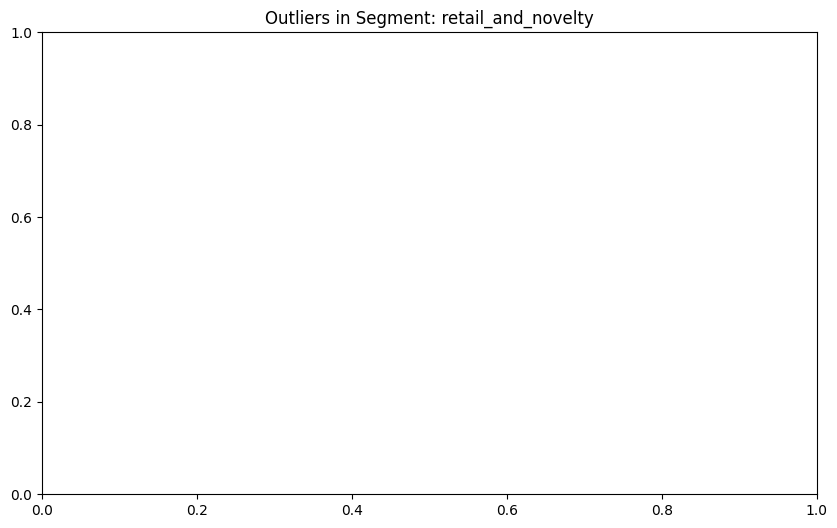

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 1% and 99% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()
    print(outliers)


In [12]:
outliers_dict = {}

segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment)
    
    # Calculate 1% and 99% percentiles for dollar sales
    lower_bound = segment_df.approxQuantile("dollar_sales", [0.01], 0.0)[0]
    upper_bound = segment_df.approxQuantile("dollar_sales", [0.99], 0.0)[0]
    
    # Filter outliers
    outliers = segment_df.filter((col("dollar_sales") < lower_bound) | (col("dollar_sales") > upper_bound))
    
    outliers_dict[segment] = outliers

# 'outliers_dict' now contains outliers for each segment
outliers_dict

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `dollar_sales` cannot be resolved. Did you mean one of the following? [`take_rate`, `name`, `merchant_abn`, `revenue_level`, `avg_median_age`].;
'Project ['dollar_sales]
+- Filter (segment#16 = garden_and_furnishings)
   +- Project [merchant_abn#0L, name#1, revenue_level#2, take_rate#3, average_merchant_fraud_probability#4, number_of_consumers#5L, average_consumer_fraud_probability#6, number_of_repeat_consumers#7L, number_of_orders#8L, average_cost_of_order#9, number_of_postcodes#10L, avg_total_weekly_personal_income#11, avg_total_weekly_fam_income#12, avg_median_age#13, avg_num_of_consumers_per_postcode#14, merchant_description#15, segment#16, log_average_cost_of_order#126, LOG1P(cast(number_of_orders#8L as double)) AS log_number_of_orders#145]
      +- Project [merchant_abn#0L, name#1, revenue_level#2, take_rate#3, average_merchant_fraud_probability#4, number_of_consumers#5L, average_consumer_fraud_probability#6, number_of_repeat_consumers#7L, number_of_orders#8L, average_cost_of_order#9, number_of_postcodes#10L, avg_total_weekly_personal_income#11, avg_total_weekly_fam_income#12, avg_median_age#13, avg_num_of_consumers_per_postcode#14, merchant_description#15, segment#16, LOG1P(average_cost_of_order#9) AS log_average_cost_of_order#126]
         +- Relation [merchant_abn#0L,name#1,revenue_level#2,take_rate#3,average_merchant_fraud_probability#4,number_of_consumers#5L,average_consumer_fraud_probability#6,number_of_repeat_consumers#7L,number_of_orders#8L,average_cost_of_order#9,number_of_postcodes#10L,avg_total_weekly_personal_income#11,avg_total_weekly_fam_income#12,avg_median_age#13,avg_num_of_consumers_per_postcode#14,merchant_description#15,segment#16] parquet
